In [1]:
# ===============================
# 1. Import Required Libraries
# ===============================
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm



In [3]:
# ===============================
# 2. Check Device
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
# ===============================
# 3. Dataset Path and Transforms
# ===============================
dataset_path = "data\source\CervicalCancer\JPEG\CROPPED_modified"  # Update if different

# Data augmentation and normalization
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val_test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\yehud\AppData\Local\Temp\ipykernel_36528\3529259581.py:4: SyntaxWarning: invalid escape sequence '\s'
  dataset_path = "data\source\CervicalCancer\JPEG\CROPPED_modified"  # Update if different


In [5]:
# ===============================
# 4. Load Dataset
# ===============================
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms["train"])
full_dataset_size = len(full_dataset)
class_names = full_dataset.classes
num_classes = len(class_names)

# Split per class to avoid leakage
def stratified_split(dataset, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    from collections import defaultdict
    from torch.utils.data import Subset

    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(idx)

    train_idx, val_idx, test_idx = [], [], []

    for indices in class_indices.values():
        n_total = len(indices)
        n_train = int(train_ratio * n_total)
        n_val = int(val_ratio * n_total)

        np.random.shuffle(indices)
        train_idx += indices[:n_train]
        val_idx += indices[n_train:n_train + n_val]
        test_idx += indices[n_train + n_val:]

    return Subset(dataset, train_idx), Subset(dataset, val_idx), Subset(dataset, test_idx)

train_set, val_set, test_set = stratified_split(full_dataset)

# Update transforms
train_set.dataset.transform = data_transforms["train"]
val_set.dataset.transform = data_transforms["val_test"]
test_set.dataset.transform = data_transforms["val_test"]

# Data loaders
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


print(f"Dataset size: {full_dataset_size}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Dataset size: 24294
Number of classes: 5
Class names: ['Dyskeratotic', 'Koilocytotic', 'Metaplastic', 'Parabasal', 'Superficial-Intermediate']


In [6]:
# ===============================
# 5. Define the Model (ResNet50)
# ===============================
model = models.resnet18(pretrained=True)

# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier for 7-class output
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout applied
    nn.Linear(512, num_classes)
)

model = model.to(device)



c:\Users\yehud\VScode\python\Visual-Validation-of-CNN-Classifications-Using-LLM\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yehud\VScode\python\Visual-Validation-of-CNN-Classifications-Using-LLM\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# ===============================
# 6. Define Loss, Optimizer
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Weight decay applied


In [8]:
# ===============================
# 7. Train the Model
# ===============================
def train_model(model, train_loader, val_loader, epochs=20):
    train_loss_log = []
    val_loss_log = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val, total_val = 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # Log
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    return model, train_loss_log, val_loss_log

# Train now
model, train_loss_log, val_loss_log = train_model(model, train_loader, val_loader)


save_dir = "data/weights"
os.makedirs(save_dir, exist_ok=True)    # ← make sure the folder is there
torch.save(model.state_dict(), os.path.join(save_dir, "cancer_resnet18_modified.pth"))


Epoch 1/20: 100%|██████████| 456/456 [00:18<00:00, 24.57it/s]


Epoch 1: Train Loss = 0.8010, Train Acc = 0.7311, Val Loss = 0.4642, Val Acc = 0.8489


Epoch 2/20: 100%|██████████| 456/456 [00:18<00:00, 25.04it/s]


Epoch 2: Train Loss = 0.4688, Train Acc = 0.8396, Val Loss = 0.3543, Val Acc = 0.8775


Epoch 3/20: 100%|██████████| 456/456 [00:17<00:00, 25.38it/s]


Epoch 3: Train Loss = 0.4070, Train Acc = 0.8597, Val Loss = 0.3135, Val Acc = 0.8923


Epoch 4/20: 100%|██████████| 456/456 [00:18<00:00, 24.71it/s]


Epoch 4: Train Loss = 0.3688, Train Acc = 0.8690, Val Loss = 0.2937, Val Acc = 0.9010


Epoch 5/20: 100%|██████████| 456/456 [00:18<00:00, 25.02it/s]


Epoch 5: Train Loss = 0.3469, Train Acc = 0.8764, Val Loss = 0.2786, Val Acc = 0.9026


Epoch 6/20: 100%|██████████| 456/456 [00:18<00:00, 24.77it/s]


Epoch 6: Train Loss = 0.3245, Train Acc = 0.8854, Val Loss = 0.2592, Val Acc = 0.9082


Epoch 7/20: 100%|██████████| 456/456 [00:18<00:00, 24.97it/s]


Epoch 7: Train Loss = 0.3069, Train Acc = 0.8910, Val Loss = 0.2534, Val Acc = 0.9111


Epoch 8/20: 100%|██████████| 456/456 [00:18<00:00, 24.83it/s]


Epoch 8: Train Loss = 0.2946, Train Acc = 0.8969, Val Loss = 0.2398, Val Acc = 0.9166


Epoch 9/20: 100%|██████████| 456/456 [00:18<00:00, 25.03it/s]


Epoch 9: Train Loss = 0.2799, Train Acc = 0.9015, Val Loss = 0.2389, Val Acc = 0.9158


Epoch 10/20: 100%|██████████| 456/456 [00:18<00:00, 25.10it/s]


Epoch 10: Train Loss = 0.2710, Train Acc = 0.9041, Val Loss = 0.2187, Val Acc = 0.9275


Epoch 11/20: 100%|██████████| 456/456 [00:18<00:00, 25.15it/s]


Epoch 11: Train Loss = 0.2518, Train Acc = 0.9107, Val Loss = 0.2141, Val Acc = 0.9263


Epoch 12/20: 100%|██████████| 456/456 [00:18<00:00, 24.35it/s]


Epoch 12: Train Loss = 0.2500, Train Acc = 0.9083, Val Loss = 0.2120, Val Acc = 0.9294


Epoch 13/20: 100%|██████████| 456/456 [00:18<00:00, 24.81it/s]


Epoch 13: Train Loss = 0.2354, Train Acc = 0.9174, Val Loss = 0.2020, Val Acc = 0.9296


Epoch 14/20: 100%|██████████| 456/456 [00:18<00:00, 25.07it/s]


Epoch 14: Train Loss = 0.2300, Train Acc = 0.9181, Val Loss = 0.1971, Val Acc = 0.9314


Epoch 15/20: 100%|██████████| 456/456 [00:19<00:00, 23.97it/s]


Epoch 15: Train Loss = 0.2265, Train Acc = 0.9202, Val Loss = 0.1881, Val Acc = 0.9310


Epoch 16/20: 100%|██████████| 456/456 [00:25<00:00, 18.23it/s]


Epoch 16: Train Loss = 0.2183, Train Acc = 0.9210, Val Loss = 0.1871, Val Acc = 0.9325


Epoch 17/20: 100%|██████████| 456/456 [00:18<00:00, 24.60it/s]


Epoch 17: Train Loss = 0.2140, Train Acc = 0.9245, Val Loss = 0.1758, Val Acc = 0.9380


Epoch 18/20: 100%|██████████| 456/456 [00:18<00:00, 24.24it/s]


Epoch 18: Train Loss = 0.2063, Train Acc = 0.9253, Val Loss = 0.1739, Val Acc = 0.9399


Epoch 19/20: 100%|██████████| 456/456 [00:18<00:00, 24.18it/s]


Epoch 19: Train Loss = 0.1968, Train Acc = 0.9316, Val Loss = 0.1704, Val Acc = 0.9401


Epoch 20/20: 100%|██████████| 456/456 [00:18<00:00, 24.61it/s]


Epoch 20: Train Loss = 0.1897, Train Acc = 0.9320, Val Loss = 0.1648, Val Acc = 0.9424


In [9]:
# ===============================
# 8. Evaluate on Test Set
# ===============================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Metrics
acc = accuracy_score(y_true, y_pred) * 100
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print("\n=== Final Test Metrics ===")
print(f"Accuracy: {acc:.2f}%")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


=== Final Test Metrics ===
Accuracy: 94.37%
F1 Score: 0.9434
Precision: 0.9436
Recall: 0.9439


In [ ]:
# ===============================
# 9. K-fold cross validation
# ===============================
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import pandas as pd

# ===============================
# Prepare target labels for stratified sampling
# ===============================
targets = [sample[1] for sample in full_dataset.samples]
targets = np.array(targets)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_metrics = []

# ===============================
# Cross-validation Loop
# ===============================
for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n------ Fold {fold + 1}/5 ------")

    # Create Subsets for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # Apply correct transforms
    train_subset.dataset.transform = data_transforms["train"]
    val_subset.dataset.transform = data_transforms["val_test"]

    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # ============================
    # Define new ResNet50 model
    # ============================
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    model = model.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

    # ============================
    # Train on this fold
    # ============================
    model, _, _ = train_model(model, train_loader, val_loader, epochs=10)

    # ============================
    # Evaluate on this fold
    # ============================
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    # Metrics
    acc = accuracy_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')

    print(f"Fold {fold + 1} - Accuracy: {acc:.2f}%, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    fold_metrics.append([acc, f1, precision, recall])

# ===============================
# Average Performance Summary
# ===============================
df = pd.DataFrame(fold_metrics, columns=["Accuracy", "F1 Score", "Precision", "Recall"])
print("\n=== Cross-Validation Performance ===")
print(df.mean())



------ Fold 1/5 ------


c:\Users\yehud\VScode\python\Visual-Validation-of-CNN-Classifications-Using-LLM\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yehud\VScode\python\Visual-Validation-of-CNN-Classifications-Using-LLM\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10: 100%|██████████| 608/608 [00:34<00:00, 17.86it/s]


Epoch 1: Train Loss = 0.6292, Train Acc = 0.7903, Val Loss = 0.3456, Val Acc = 0.8837


Epoch 2/10: 100%|██████████| 608/608 [00:33<00:00, 18.00it/s]


Epoch 2: Train Loss = 0.3880, Train Acc = 0.8629, Val Loss = 0.3006, Val Acc = 0.8932


Epoch 3/10: 100%|██████████| 608/608 [00:33<00:00, 18.09it/s]


Epoch 3: Train Loss = 0.3407, Train Acc = 0.8781, Val Loss = 0.2860, Val Acc = 0.8967


Epoch 4/10: 100%|██████████| 608/608 [00:35<00:00, 17.09it/s]


Epoch 4: Train Loss = 0.3197, Train Acc = 0.8836, Val Loss = 0.2324, Val Acc = 0.9160


Epoch 5/10: 100%|██████████| 608/608 [00:43<00:00, 13.89it/s]


Epoch 5: Train Loss = 0.2986, Train Acc = 0.8929, Val Loss = 0.2346, Val Acc = 0.9146


Epoch 6/10: 100%|██████████| 608/608 [00:42<00:00, 14.44it/s]


Epoch 6: Train Loss = 0.2820, Train Acc = 0.8995, Val Loss = 0.2157, Val Acc = 0.9181


Epoch 7/10: 100%|██████████| 608/608 [00:41<00:00, 14.49it/s]


Epoch 7: Train Loss = 0.2690, Train Acc = 0.9023, Val Loss = 0.2163, Val Acc = 0.9212


Epoch 8/10: 100%|██████████| 608/608 [00:42<00:00, 14.27it/s]


Epoch 8: Train Loss = 0.2564, Train Acc = 0.9090, Val Loss = 0.2009, Val Acc = 0.9255


Epoch 9/10:  62%|██████▏   | 374/608 [00:26<00:18, 12.44it/s]

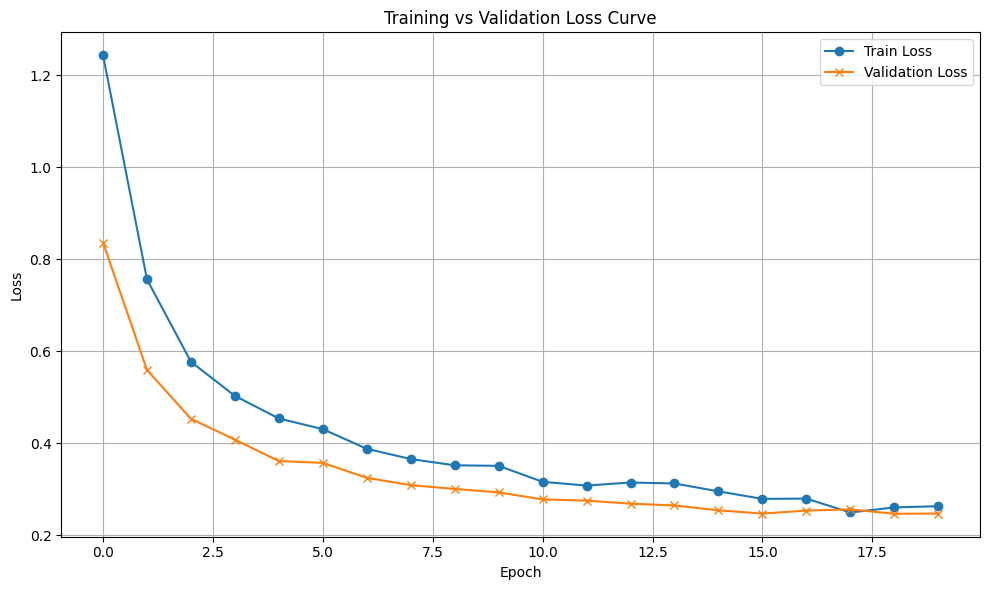

In [ ]:
# ===============================
# 10. Plot Loss Curve
# ===============================
def plot_loss_curves(train_log, val_log):
    plt.figure(figsize=(10, 6))
    plt.plot(train_log, label='Train Loss', marker='o')
    plt.plot(val_log, label='Validation Loss', marker='x')
    plt.title("Training vs Validation Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(train_loss_log, val_loss_log)
